Backpropagation is an algorithm that allows efficiently evaluate the gradient of a loss function with respect to weights of a neural network. It allows to iteratively tune the weight of a neural network to minimize the loss function; therefor improve accuracy of the neural network.

# Example: Autodifferentiation with JAX

In [213]:
import jax
import math

In [16]:
import jax.numpy as jnp
from jax import jit, grad
from jax import Array
from jax.typing import ArrayLike

import matplotlib.pyplot as plt

Let's start from a simple function. While we know the global minimum, a computer does not.

In [86]:
def square(X: ArrayLike) -> Array:
    return (X + 2) ** 2

# Compile once, compute much faster in the future.
square_compiled = jit(square)

In [87]:
x = jnp.linspace(-9, 9, 90)
y = square_compiled(x)

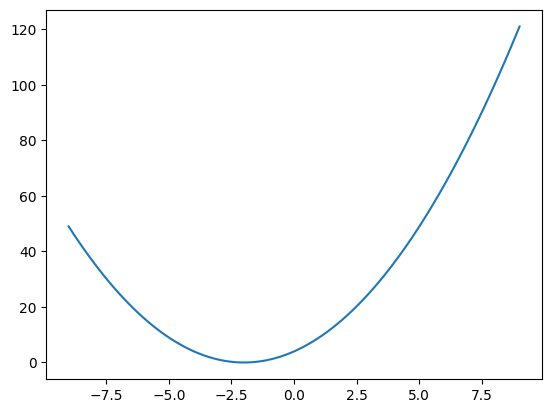

In [88]:
plt.plot(x, y)

JAX provides automatic differentiation via the `jax.grad` transformation.  
`grad` properly calculated the derivative of a function $f'(square) = 2*(x+2)$ and I could get its value.

In [90]:
derivative_fn = jit(grad(square_compiled))  # Yes, we can compile derivative function too.

In [91]:
print(derivative_fn(jnp.float32(-2)))  # derivative at x=-2 → 2*(-2+2) = 0

0.0


Our goal to get to minimum as close as we can.

In [188]:
point = 5
for _ in range(25):
    res = derivative_fn(jnp.float32(point))
    print(f"f'(x)={res} | x={point}")
    point -= res * 0.1

f'(x)=14.0 | x=5
f'(x)=11.199999809265137 | x=3.5999999046325684
f'(x)=8.960000038146973 | x=2.4800000190734863
f'(x)=7.168000221252441 | x=1.5839999914169312
f'(x)=5.734399795532227 | x=0.8671999573707581
f'(x)=4.587519645690918 | x=0.29375994205474854
f'(x)=3.670015811920166 | x=-0.16499203443527222
f'(x)=2.9360127449035645 | x=-0.5319936275482178
f'(x)=2.3488101959228516 | x=-0.8255949020385742
f'(x)=1.8790481090545654 | x=-1.0604759454727173
f'(x)=1.5032384395599365 | x=-1.2483807802200317
f'(x)=1.2025907039642334 | x=-1.3987046480178833
f'(x)=0.9620726108551025 | x=-1.5189636945724487
f'(x)=0.769658088684082 | x=-1.615170955657959
f'(x)=0.6157264709472656 | x=-1.6921367645263672
f'(x)=0.4925811290740967 | x=-1.7537094354629517
f'(x)=0.39406490325927734 | x=-1.8029675483703613
f'(x)=0.31525182723999023 | x=-1.8423740863800049
f'(x)=0.25220155715942383 | x=-1.873899221420288
f'(x)=0.20176124572753906 | x=-1.8991193771362305
f'(x)=0.1614089012145996 | x=-1.9192955493927002
f'(x)=0.12

# Derivatives

If we slightly bump-up, slightly increase by a small number $h$ some point $x$ - how the function respond? With what sensitivity it will respond, what is the slope at this point? Does the function go up or down and by how much? It is what the value of the derivative function at point $x$ is. 

$$ f'(x) = \lim_{h \to 0} \frac{f(x + h) - f(x)}{h} $$

In [93]:
def f(x): return 3*x**2 - 4*x + 5

In [100]:
h = 0.000001  # <--- smaller is better to converge. But obviously we can't go to zero.
x = 3
(f(x+h) - f(x)) / h  # Looks about right! f'(x) = 6x - 4; f'(3) = 6*3 - 4 = 18 - 4 = 14

14.000003002223593

The function can have more than one argument and we can check how each of them is contributing to the direction of getting to lower values of a function

In [102]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

# Let's check how a small nudge of b will contribute to a slope
d1 = a*b - c
d2 = a*(b+h) - c

print(f"d1: {d1}")
print(f"d2: {d2}")
print(f"Slope: {(d2 - d1) / h}")  # Make sense since df/db = a. a = 2.0.

d1: -16.0
d2: -15.9998
Slope: 1.9999999999953388


Slope is basically rise over run:

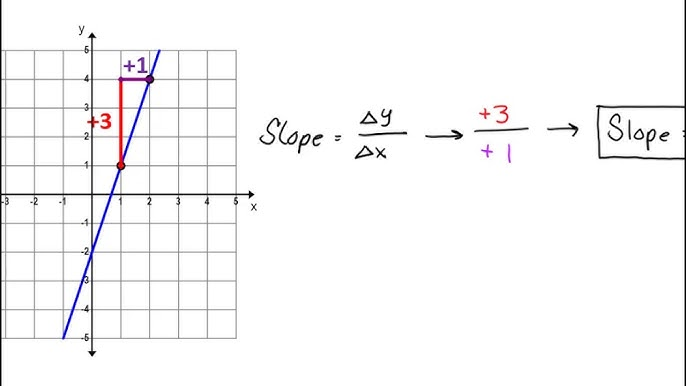

# Backpropagation

To successfully track the direction in which we should move to minimize a function's value, we need to know what transformation this particular value underwent during the forward pass. We need to track what values produced other values.  
Built-in numerical types do not do this. Hence, we need to introduce our own container `Value`.

In [230]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label="undef"):  # _children tracks from what values this one was derived, 
                                                                          # while _op looks at the operation it was derived from
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0  # the derivative of L with respect to this value. Default zero means that this value does not affect L.
                         # Zero means that changing this variable does not change the loss function.
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")  # an example of using "children". New value is a sum of the current value and the other values.
                                                                 # Hence we pass as children "self" and "other" instances.
                                                                 # We must also track what was done with "children", what operation brought on self and other
                                                                 # brought us to this new value.
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tahn')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

print(f)

Value(data=-2.0)


It is now clear that we can visualize these operations on values as a computational DAG. The specific implementation of visualization does not matter much, so I just copy-paste the code with no explanations since we only want to see the actual graph itself.

In [173]:
from graphviz import Digraph

In [174]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "%s | { data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

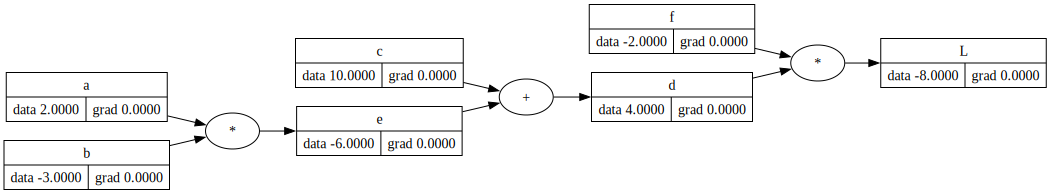

In [184]:
draw_dot(L)

So far, we can do a forward pass and build-up mathematical expression which produces a single output $f$.  
We also track how we get to this expression. 

You can imagine that if we replace $f$ with a loss function $L$ we can get the value of the loss function and know exactly how we arrive to a specific value.

We now want to run a back propagation. We are going to start at the end and we are going to reverse and calculate the gradient along all intermediate values. We will compute a derivative of $L$ with respect to all other values: $a$, $b$, $c$, and $d$. In real neural networks we will probably not touch $a$ and $b$ because it is our input data and it is fixed. So we will only consider:

$$ \frac{dL}{dd}, \frac{dL}{dc}, \frac{dL}{de}, \frac{dL}{df} $$

So, we need to create a variable within the `Value` class that maintains derivative of $L$ with respect to that value. Let's call it `grad`.

Before we can switch to doing derivatives automatically, lets go back to $h$ and check how we can do backpropagation manually!

In [195]:
def lol():
    
    h = 0.01
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0 + h, label='f')  # <--- we nudge f by h
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1)/h)

lol()

4.0000000000000036


So we can see that $\frac{dL}{dd} = -2$ and $\frac{dL}{df} = 4$. Which is exactly right since $L = d*f, L'(d) = f$.  

But what will happen if we can one more step backward? Do we need to accumulate gradients? We need to derive $\frac{dL}{dc}$! We know how $L$ is sensitive to $d$, but how $L$ is sensitive to $c$?! We already know the impact of $c$ to $d$ and we know the impact of $d$ to $L$. So how $c$ impacts $L$? The answer is a [chain rule](https://en.wikipedia.org/wiki/Chain_rule).

*If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."*

$$ \frac{dL}{dc} = \frac{dL}{dd} * \frac{dd}{dc} = 4 * 1 = -2 $$

In [199]:
def lol():
    
    h = 0.01
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0 + h, label='c')  # <--- we nudge c by h
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f') 
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1)/h)

lol()

-1.9999999999999574


In [200]:
c.grad = -2
e.grad = -2
d.grad = -2
f.grad = 4
L.grad = 1

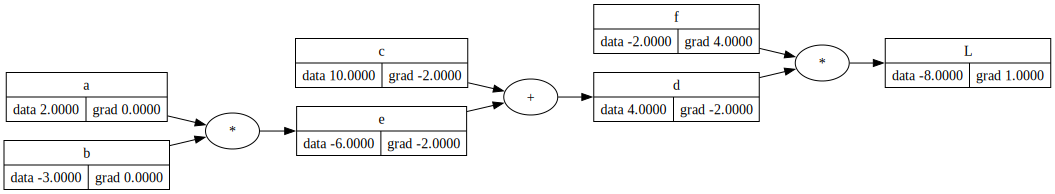

In [201]:
draw_dot(L)

So whenever we have "+" operation the gradient is basically flowing all the way back to the nodes. "+" will simply distribute the derivative to all the children nodes of it. 

We can now recursively apply for the last "*" operator. It is very easy now! We know $\frac{dL}{de} = -2$. We now want $\frac{dL}{da}$. Chain rule tells us that it is $\frac{dL}{da} = \frac{dL}{de} * \frac{de}{da} = -2 * -3 = 6$ (-3 is basically what is in $b$ because $e = a*b, e'(a) = b$. Let's check it numerically! 

In [204]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

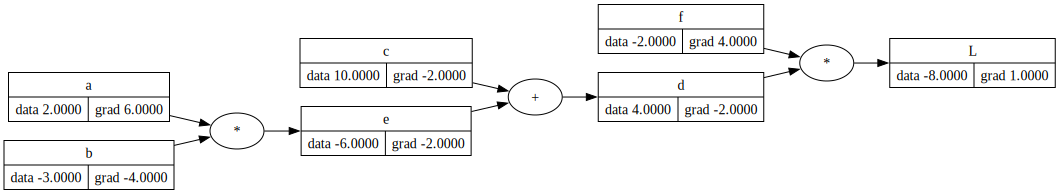

In [205]:
draw_dot(L)

Let's do quick verification!

In [206]:
def lol():
    
    h = 0.01
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f') 
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1)/h)

lol()

5.999999999999872


# Backpropagation Through Neuron

Biologically neurons are very complex devices. But we have a very simple mathematical models of them for building neural network.

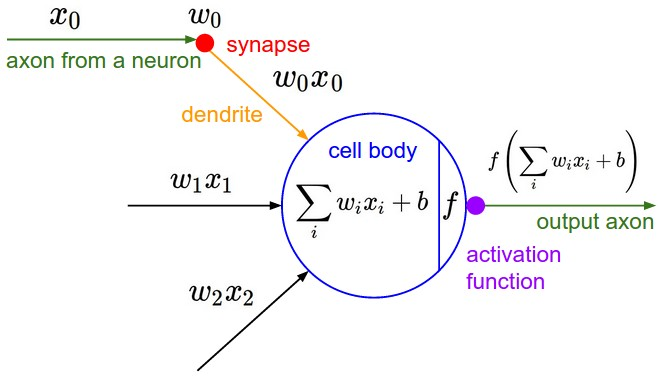

For the purposes of this section, we are going to use tanh function:

In [209]:
import numpy as np

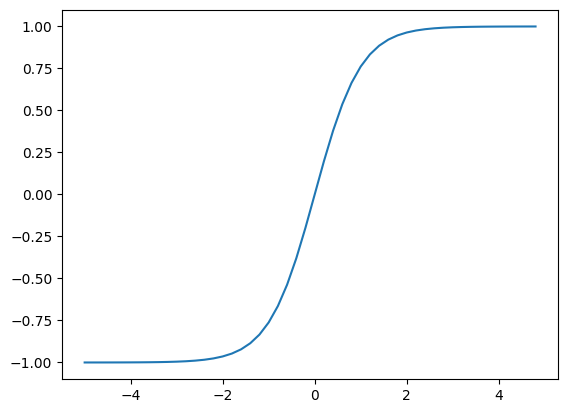

In [210]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))

In [251]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')  # Only to make some downstream numbers nice.
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

There is a missing bit in the implementation in this neuron: `tenh` (tangens) function.  
`tenh` is a hyperbolic function. But we only implemented plus and multiple.

$$\tanh(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

Since we already have sum operation in our base class, we can add exp() and we should be good to go 👍 But we will implement `tehn` directly. Here is why.

It is totally up to us what functions we want to implement in our base class. We can make any function a single node — provided they also supply the differentiation rule for that node. The function could be of any complexity or level of abstraction (fused vs. primitive ops) we want. Fused nodes are more numerically stable and faster on GPU (one kernel launches instead of multiple). FlashAttention is the extreme version of this — the entire scaled dot-product attention becomes one fused kernel. 

The tradeoff is between letting the compiler fuse things automatically (more flexible, sometimes suboptimal) versus hand-writing fused ops (more work, potentially faster or more numerically stable).

In [252]:
o = n.tanh(); o.label = 'o'; o.grad = 1

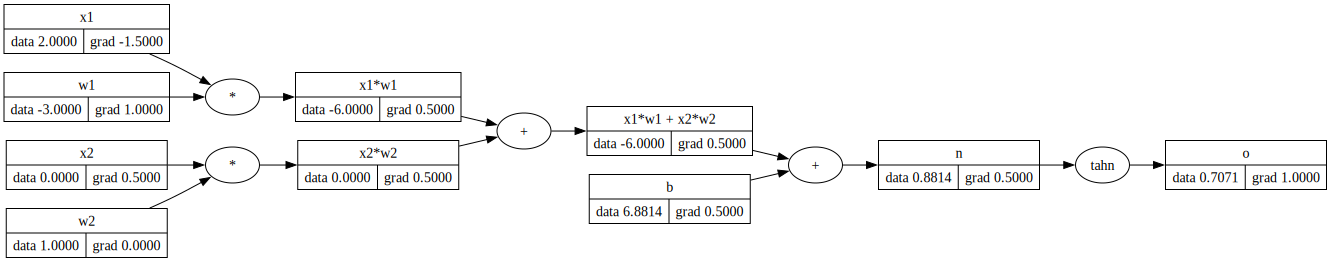

In [265]:
draw_dot(o)

We are now looking for all derivatives like: $\frac{do}{dx1}$, $\frac{do}{dw1}$, etc. When I was learning how auto differentiation works for the first time, I was always confused how can it take derivatives of function. It was a deep misunderstanding.  
We must provide derivatives of functions to enable back propagation on a node where this function is used. For example: $ o = \tanh(o), \frac{do}{dn} = 1 - \tanh(h)^2 $ sine $\tanh(h) = 0, \frac{do}{dn} = 1 - o^2$.

Automatic differentiation frameworks like PyTorch and JAX work by decomposing computations into a graph of primitive operations, each of which has a registered derivative rule. f your computation includes an operation that:

1. Is not a registered primitive in the framework, and
2. Cannot be decomposed into a sequence of operations that are registered primitives

…then autodiff will fail, regardless of whether the mathematical derivative exists on paper.

In [257]:
n.grad = 1 - o.data**2

In [259]:
# "+" will simply flow derivatives:
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5

In [264]:
# "*" is different
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad